In [1]:
import os, platform, pprint, sys
import fastai
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

from fastai.tabular.data import TabularDataLoaders
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, ShowGraphCallback


seed: int = 14


# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint


# declare file paths for the data we will be working on
data_path_1: str = '../data/prepared/baseline/'
data_path_2: str = '../data/prepared/timebased/'
modelPath  : str = './models'


# list the names of the datasets we will be using
attacks : list = [ 'DNS', 'LDAP', 'MSSQL', 'NetBIOS', 'NTP', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDPLag' ]
datasets: list = [
    "DNS_vs_benign.csv" , "LDAP_vs_benign.csv"    , "MSSQL_vs_benign.csv" , "NetBIOS_vs_benign.csv" ,
    "NTP_vs_benign.csv" , "Portmap_vs_benign.csv" , "SNMP_vs_benign.csv"  , "SSDP_vs_benign.csv"    ,
    "Syn_vs_benign.csv" , "TFTP_vs_benign.csv"    , "UDP_vs_benign.csv"   , "UDPLag_vs_benign.csv"  ,
]



# print library and python versions for reproducibility
print(
    f'''
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tsklearn:\t{sklearn.__version__}
    '''
)


    python:	3.7.10

    	fastai:		2.4.1
    	matplotlib:	3.3.4
    	numpy:		1.20.3
    	pandas:		1.2.5
    	sklearn:	0.24.2
    


In [2]:
def get_file_path(directory: str):
    '''
        Closure that will return a function that returns the filepath to the directory given to the closure
    '''

    def func(file: str) -> str:
        return os.path.join(directory, file)

    return func


# use the get_file_path closure to create a function that will return the path to a file
baseline_path  = get_file_path(data_path_1)
timebased_path = get_file_path(data_path_2)


# create a list of the paths to all of the dataset files
baseline_files : list = list(map(baseline_path , datasets))
timebased_files: list = list(map(timebased_path, datasets))

In [3]:
def load_data(filePath: str) -> pd.DataFrame:
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
        After the data is loaded, the benign samples are split and saved in a list
        the malicious samples are split and saved in a dictionary of lists indexed by attack type
        only the top million malicious samples are kept
    '''

    # slice off the ./CSV/ from the filePath
    if filePath[0] == '.' and filePath[1] == '.':
        filePathClean: str = filePath[17::]
        pickleDump: str = f'../data/cache/{filePathClean}.pickle'
    else:
        pickleDump: str = f'../data/cache/{filePath}.pickle'
    
    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')
    
    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
        
    # if not, load data and cache it
    else:
        df = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)

    
    return df


def run_experiment(df, name):
    '''
        Run binary classification on a given dataframe, saving the model as {name}.model
    '''
    dep_var: str = 'Label'
    unused_categories: list = []
    selected_features = list(set(df) - set(unused_categories) - set([dep_var]))

    procs = [FillMissing, Categorify, Normalize]

    tdl = TabularDataLoaders.from_df(df, path=modelPath, y_names=dep_var, cat_names=[], cont_names=selected_features, procs=procs)

    model = tabular_learner(tdl, layers=[50, 28], metrics=accuracy, cbs=ShowGraphCallback)
    model.fit_one_cycle(10)
    model.save(f'{name}.model')


    loss, acc = model.validate()
    print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

    # preds, y, decoded, losses = model.get_preds(with_loss=True, with_decoded=True)

    interp = ClassificationInterpretation.from_learner(model)
    # interp = ClassificationInterpretation(model, preds, y, losses)
    interp.plot_confusion_matrix()

In [4]:
baseline_dfs : list = list(map(load_data   , baseline_files ))
timebased_dfs: list = list(map(load_data   , timebased_files))
experiments  : list = list(zip(baseline_dfs, timebased_dfs  , attacks))

Loading Dataset: ../data/prepared/baseline/DNS_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/DNS_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/LDAP_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/LDAP_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/MSSQL_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/MSSQL_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/NetBIOS_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/NetBIOS_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/NTP_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/NTP_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/Portmap_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/Portmap_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/SNMP_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/SNMP_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/SSDP_vs_benign.csv
	To Dataset

In [5]:
def experiment_runner():
    for baseline, timebased, attack in experiments:
        run_experiment(baseline, f'{attack}_baseline')
        run_experiment(timebased, f'{attack}_timebased')
        yield


experiment = experiment_runner()

epoch,train_loss,valid_loss,accuracy,time
0,0.001117,0.132322,0.998536,00:24
1,0.001971,0.054475,0.999069,00:23
2,0.001798,0.058957,0.999401,00:23
3,0.001478,0.099157,0.999202,00:23
4,0.002337,0.063250,0.999401,00:24
5,0.002223,0.057409,0.999534,00:22
6,0.000223,0.034112,0.996496,00:22
7,0.000509,0.091256,0.998869,00:22
8,0.000438,0.071269,0.999246,00:22
9,0.000256,0.059711,0.998425,00:22


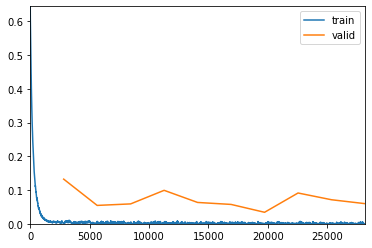

loss 0.059710513800382614: accuracy: 99.84%


epoch,train_loss,valid_loss,accuracy,time
0,0.080192,0.306585,0.911581,00:21
1,0.052173,0.214575,0.920496,00:21
2,0.044723,0.310224,0.897388,00:21
3,0.038538,0.335562,0.898785,00:21
4,0.028471,0.265098,0.898763,00:21
5,0.034506,0.332382,0.896700,00:21
6,0.029345,0.360524,0.892265,00:21
7,0.022344,0.381085,0.892287,00:22
8,0.026257,0.390297,0.895148,00:21
9,0.028619,0.452553,0.892509,00:21


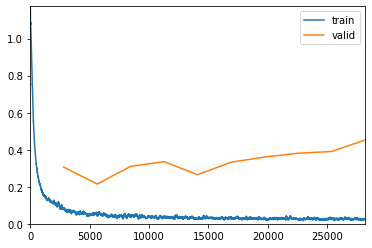

loss 0.45255324244499207: accuracy: 89.25%


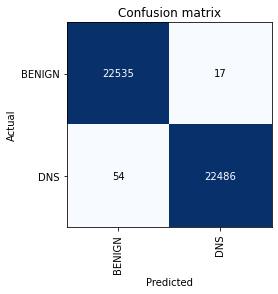

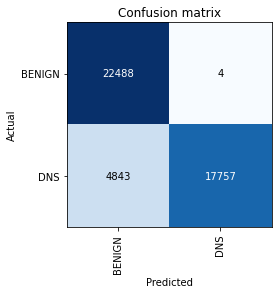

In [6]:
next(experiment)

epoch,train_loss,valid_loss,accuracy,time
0,0.003193,0.000774,0.999867,00:22
1,0.000787,0.005597,0.999889,00:21
2,0.002254,0.024663,0.999889,00:22
3,0.000325,0.001017,0.999867,00:22
4,0.000120,0.001085,0.999867,00:22
5,0.000218,0.017500,0.999756,00:22
6,0.000985,0.024270,0.999468,00:22
7,0.000055,0.022763,0.999579,00:22
8,0.000040,0.050216,0.998825,00:22
9,0.000326,0.020688,0.998093,00:22


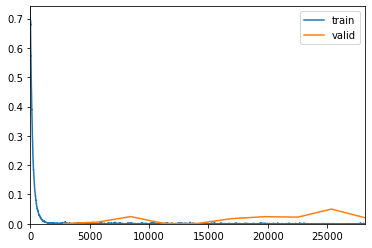

loss 0.020687811076641083: accuracy: 99.81%


epoch,train_loss,valid_loss,accuracy,time
0,0.035967,0.190292,0.968376,00:21
1,0.015111,0.114423,0.971880,00:21
2,0.013827,0.172862,0.969773,00:21
3,0.015580,0.165335,0.971547,00:21
4,0.010713,0.164712,0.970372,00:21
5,0.006950,0.062754,0.972612,00:21
6,0.004859,0.094257,0.972501,00:21
7,0.007492,0.080644,0.972589,00:21
8,0.004319,0.065586,0.972612,00:21
9,0.005621,0.061812,0.972545,00:22


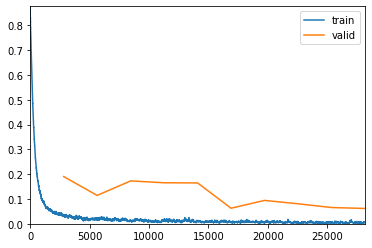

loss 0.061812303960323334: accuracy: 97.25%


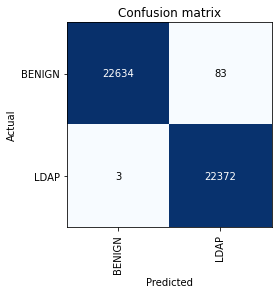

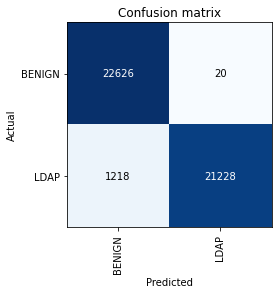

In [7]:
next(experiment)

epoch,train_loss,valid_loss,accuracy,time
0,0.001155,0.000448,0.999933,00:22
1,0.000688,0.000455,0.999956,00:20
2,0.000250,0.000460,0.999911,00:22
3,0.000659,0.000362,0.999956,00:21
4,0.000475,0.000388,0.999956,00:21
5,0.000431,0.000368,0.999933,00:22
6,0.001244,0.000362,0.999956,00:22
7,0.000023,0.000327,0.999956,00:22
8,0.000056,0.000730,0.999845,00:22
9,0.000193,0.000450,0.999933,00:22


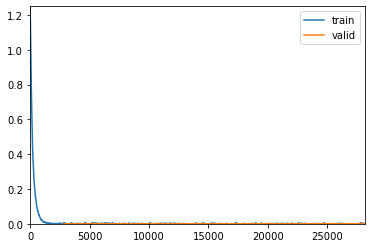

loss 0.0004502719675656408: accuracy: 99.99%


epoch,train_loss,valid_loss,accuracy,time
0,0.039680,0.601462,0.927814,00:21
1,0.036374,0.389122,0.946021,00:21
2,0.030987,0.289249,0.948394,00:21
3,0.025901,0.156481,0.948572,00:21
4,0.023932,0.223932,0.940610,00:21
5,0.023987,0.113151,0.949548,00:21
6,0.021468,0.327984,0.923689,00:22
7,0.023968,0.153355,0.948439,00:21
8,0.018871,0.204501,0.948173,00:21
9,0.013209,0.223905,0.947707,00:21


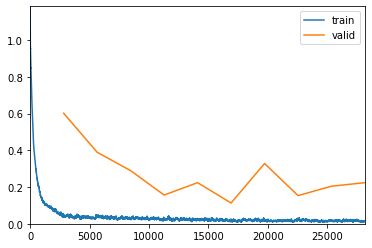

loss 0.22390486299991608: accuracy: 94.77%


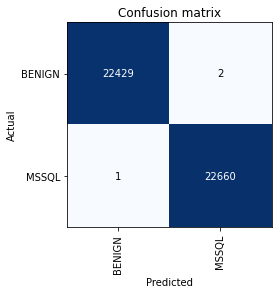

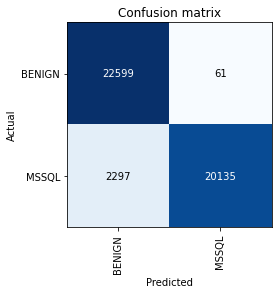

In [8]:
next(experiment)

epoch,train_loss,valid_loss,accuracy,time
0,0.004434,0.005266,0.998692,00:23
1,0.001896,0.003473,0.999113,00:22
2,0.000923,0.094564,0.997184,00:22
3,0.005521,0.006838,0.998958,00:22
4,0.001528,0.017388,0.999091,00:21
5,0.002097,0.004486,0.999401,00:22
6,0.000927,0.009310,0.999179,00:22
7,0.000936,0.004437,0.999423,00:22
8,0.001317,0.005473,0.999423,00:22
9,0.001375,0.009021,0.999246,00:22


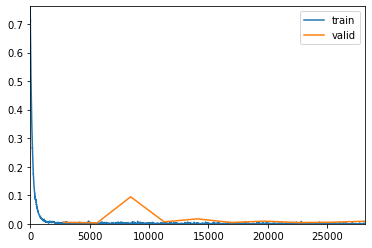

loss 0.009020905941724777: accuracy: 99.92%


epoch,train_loss,valid_loss,accuracy,time
0,0.038873,0.221805,0.911204,00:21
1,0.031119,0.704215,0.911071,00:21
2,0.028899,0.427376,0.909629,00:21
3,0.023372,0.456251,0.908387,00:21
4,0.023783,0.306013,0.865342,00:22
5,0.011471,0.242516,0.910161,00:21
6,0.014544,0.164935,0.908498,00:22
7,0.014391,0.295795,0.908720,00:21
8,0.008999,0.135557,0.909629,00:22
9,0.013465,0.152988,0.910228,00:22


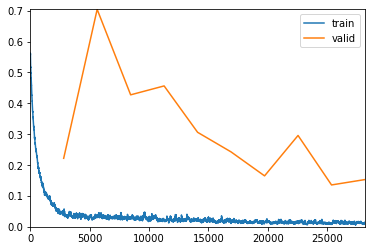

loss 0.15298821032047272: accuracy: 91.02%


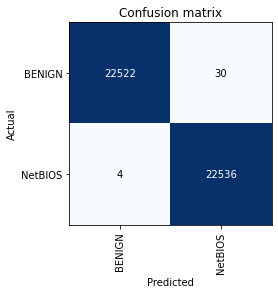

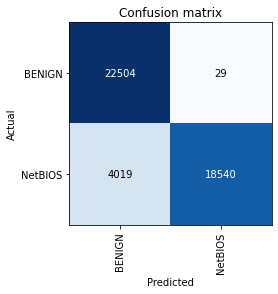

In [9]:
next(experiment)

epoch,train_loss,valid_loss,accuracy,time
0,0.008454,0.010781,0.997605,00:22
1,0.008032,0.008371,0.998603,00:21
2,0.008937,0.006995,0.998514,00:22
3,0.005284,0.009471,0.998137,00:22
4,0.004247,0.013291,0.998292,00:22
5,0.003285,0.058221,0.997760,00:23
6,0.007591,0.007380,0.998736,00:23
7,0.008541,0.007697,0.998669,00:22
8,0.004891,0.007230,0.998669,00:23
9,0.008284,0.005698,0.998936,00:23


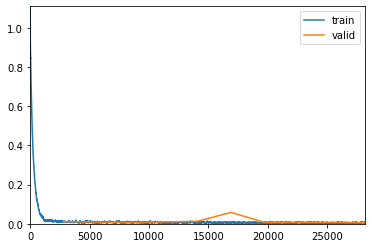

loss 0.005697966553270817: accuracy: 99.89%


epoch,train_loss,valid_loss,accuracy,time
0,0.120569,0.321219,0.816131,00:21
1,0.082003,0.230524,0.897942,00:21
2,0.073736,0.313084,0.870908,00:21
3,0.068702,0.624432,0.662401,00:21
4,0.062871,0.244298,0.870332,00:21
5,0.046680,0.411270,0.821143,00:21
6,0.056728,0.373329,0.809257,00:21
7,0.061827,0.334869,0.818327,00:21
8,0.045234,0.363636,0.811119,00:21
9,0.042337,0.773984,0.672203,00:22


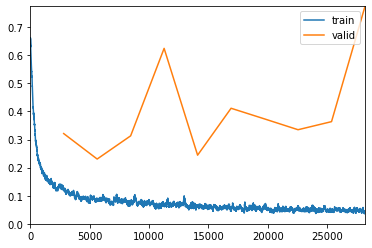

loss 0.7739839553833008: accuracy: 67.22%


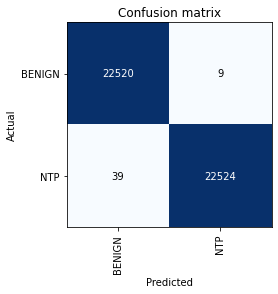

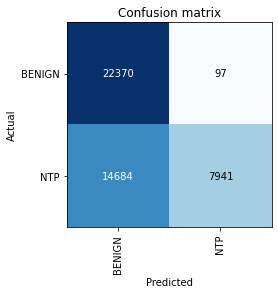

In [10]:
next(experiment)

epoch,train_loss,valid_loss,accuracy,time
0,0.003112,0.008141,0.998891,00:22
1,0.005257,0.025840,0.998958,00:22
2,0.004858,0.029591,0.999046,00:22
3,0.003116,0.263473,0.998492,00:22
4,0.002315,0.220935,0.998248,00:21
5,0.001934,0.048219,0.998936,00:21
6,0.004301,0.201730,0.998869,00:20
7,0.001802,0.214079,0.998692,00:21
8,0.001457,0.167848,0.998980,00:21
9,0.004906,0.127489,0.999335,00:22


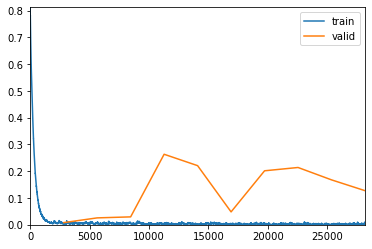

loss 0.12748949229717255: accuracy: 99.93%


epoch,train_loss,valid_loss,accuracy,time
0,0.048121,0.167706,0.932871,00:21
1,0.034486,0.495205,0.931850,00:21
2,0.037550,0.339043,0.930298,00:22
3,0.028719,0.291562,0.930254,00:22
4,0.021734,0.295510,0.930387,00:21
5,0.025719,0.348467,0.930387,00:21
6,0.021540,0.311121,0.930365,00:21
7,0.022731,0.282972,0.930475,00:21
8,0.020135,0.264821,0.930542,00:21
9,0.015626,0.299514,0.930697,00:21


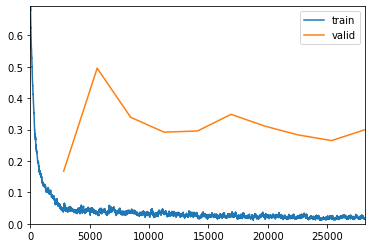

loss 0.2995135188102722: accuracy: 93.07%


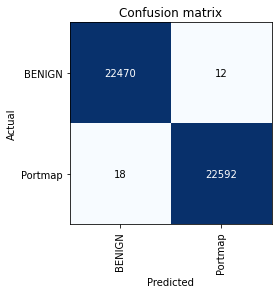

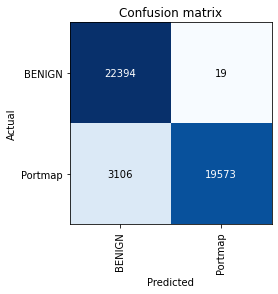

In [11]:
next(experiment)

epoch,train_loss,valid_loss,accuracy,time
0,0.002449,0.278016,0.999556,00:21


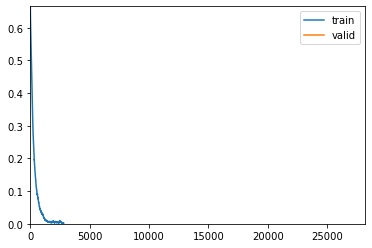

In [12]:
next(experiment)

In [ ]:
next(experiment)

In [ ]:
next(experiment)

In [ ]:
next(experiment)

In [ ]:
next(experiment)

In [ ]:
next(experiment)